### **Pytorch一般有以下几个流程**


- 1. 数据读取

- 2. 数据处理

- 3. 搭建网络

- 4. 模型训练

- 5. 模型上线

## 1. 数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 在指定GPU运行，比如第一个GPU就是0，如果多个GPU，就是"0,1"

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary

d:\miniconda3\envs\torch11\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [2]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    # transforms.RandomCrop(32,padding=4), # 数据增广
    # transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [3]:
Batch_Size = 64

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2, drop_last=True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2. 查看数据（格式，大小，形状）

In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [8]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    


 ## 3. 查看图片

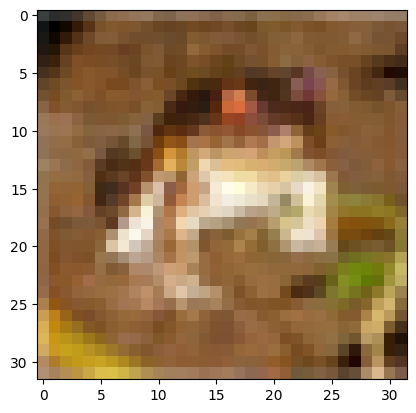

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

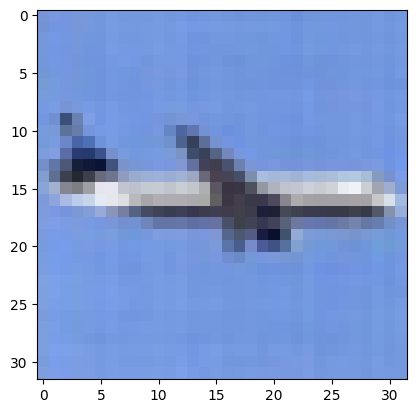

In [11]:
imshow(im[0])

In [12]:
im[0].shape

torch.Size([3, 32, 32])

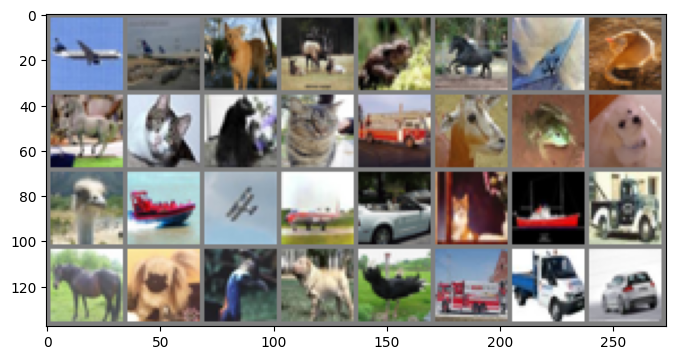

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

## 4. 定义网络（Swin Transformer）

自从Transformer在NLP任务上取得突破性的进展之后，业内一直尝试着把Transformer用于在CV领域。之前的若干尝试，例如iGPT，ViT都是将Transformer用在了图像分类领域，ViT我们之前也有介绍过在图像分类上的方法，但目前这些方法都有两个非常严峻的问题

1. **受限于图像的矩阵性质**，一个能表达信息的图片往往至少需要几百个像素点，而**建模这种几百个长序列的数据**恰恰是Transformer的天生缺陷；
2. 目前的基于Transformer框架更多的是用来进行图像分类，理论上来讲解决检测问题应该也比较容易，但是对**实例分割这种密集预测的场景**Transformer并不擅长解决。

而这篇微软亚洲研究院提出的的Swin Transformer解决了这两个问题，并且在分类，检测，分割任务上都取得了SOTA的效果，同时获得了**ICCV2021的best paper**。Swin Transformer的最大贡献是提**出了一个可以广泛应用到所有计算机视觉领域的backbone**，并且大多数在CNN网络中常见的超参数在Swin Transformer中也是可以人工调整的，例如可以调整的网络块数，每一块的层数，输入图像的大小等等。该网络架构的设计非常巧妙，是一个非常精彩的将Transformer应用到图像领域的结构，值得每个AI领域的人前去学习。

![img](https://pic4.zhimg.com/80/v2-f55babd13885e3c867084ed28d0090e3_720w.webp)



实际上的，Swin Transformer 是在 Vision Transformer 的基础上使用滑动窗口（shifted windows, SW）进行改造而来。它将 Vision Transformer 中固定大小的采样快按照层次分成不同大小的块（Windows），每一个块之间的信息并不共通、独立运算从而大大提高了计算效率。从 Swin Transformer 的架构图中可以看出其与 Vision Transformer 的结构很相似，不同的点在于其采用的 Transformer Block 是由**两个连续的 Swin Transformer Block 构成**的，这两个 Block 块与 Vision Transformer中的 Block 块大致相同，只是将 Multi-head Self-Attention（MSA）替换成了含有**不同大小 Windows 的 W-MSA 与 SW-MAS** （具有滑动窗口, SW），通过 Windows 和 Shifted Windows 的 Multi-head Self-Attention 提高运算效率并最终**提高分类的准确率**。

###  Swin Transformer整体架构

从 Swin Transformer 网络的整体框架图我们可以看到，首先将输入图像 I 输入到 Patch Partition 进行一个分块操作，这一部分其实是和VIT是一样的，然后送入 Linear Embedding 模块中进行通道数 channel 的调整。最后通过 stage 1, 2, 3 和 4 的特征提取和下采样得到最终的预测结果，值得注意的是每经过一个 stage，size 就会 缩小为原来的 1/2，channel 就会扩大为原来的 2 倍，与 resnet 网络类似。每个 stage 中的 Swin Transformer Block 都由两个相连的分别以 W-MSA 和 SW-MSA 为基础的 Transformer Block 构成，通过 Window 和 Shifted Window 机制提高计算性能。 最右边两个图为Swim Transformer的每个块结构，类似于ViT的块结构，其核心修改的地方就是将原本的MSA变为W-MSA。

![Video Swin Transformer - Kamino's Blog](https://kamino-img.oss-cn-beijing.aliyuncs.com/20210806101614.png)





### Patch Merging

Patch Merging 模块将 尺寸为 $H \times W$ 的 Patch 块首先进行拼接并在 channel 维度上进行 concatenate 构成了 $H/2 \times W/2 \times 4C$  的特征图，然后再进行 Layer Normalization 操作进行正则化，然后通过一个 Linear 层形成了一个 $H/2 \times W/2 \times 2C$ ，完成了特征图的下采样过程。其中 size 缩小为原来的 1/2，channel 扩大为原来的 2 倍。

这里也可以举个例子，假设我们的输入是4×4大小单通道的特征图，首先我们会隔一个取一个小Patch组合在一起，最后4×4的特征图会行成4个2×2的特征图。接下来将4个Patch进行拼接，现在得到的特征图尺寸为2×2×4。然后会经过一个LN层，这里当然会改变特征图的值，我改变了一些颜色象征性的表示了一下，LN层后特征图尺寸不会改变，仍为2×2×4。最后会经过一个全连接层，将特征图尺寸由2×2×4变为2×2×2。

![img](https://pic4.zhimg.com/80/v2-818b0a671184f4e31d568fb065b5c507_720w.webp)





### W-MSA 

ViT 网络中的 MSA 通过 **Self-Attention** 使得每一个像素点都可以和其他的像素点进行内积从而得到所有像素点的信息，从而获得丰富的全局信息。但是每个像素点都需要和其他像素点进行信息交换，计算量巨大，网络的执行效率低下。因此 Swin-T 将 **MSA 分个多个固定的 Windows 构成了 W-MSA**，每个 Windows 之间的像素点只能与该 Windows 中的其他像素点进行内积从而获得信息，这样便大幅的减小了计算量，提高了网络的运算效率。

![Swin Transformer原理详解篇- 掘金](https://p3-juejin.byteimg.com/tos-cn-i-k3u1fbpfcp/519e56036b1c418bae288833e50de049~tplv-k3u1fbpfcp-zoom-in-crop-mark:1512:0:0:0.awebp)

MSA 和 W-MAS 的计算量如下所示：
$$
\begin{aligned}
& \Omega(M S A)=4 h w C^2+2(h w)^2 C \\
& \Omega(W-M S A)=4 h w C^2+2 M^2 h w C
\end{aligned}
$$



其中 $\mathrm{h} 、 \mathrm{w}$ 和 $C$ 分别代表特征图的高度、宽度和深度， $M$ 代表每个 Windows 的大小。

假定 $h=w=64, M=4, C=96$ 。

采用MSA模块的计算复杂度为 $4\times64\times64\times96^2 +2\times(64\times64)^2\times96 = 3372220416$

采用W-MSA模块的计算复杂度为 $4\times64\times64\times96^2 +2\times4^2\times64\times64\times96 = 163577856$

可以计算出 W-MSA 节省了3208642560 FLOPs。

### SW-MSA

虽然 W-MSA 通过划分 Windows 的方法减少了计算量，但是由于**各个 Windows 之间无法进行信息的交互**，因此可以看作其“感受野”缩小，无法得到较全局准确的信息从而影响网络的准确度。为了实现不同窗口之间的**信息交互**，我们可以将**窗口滑动**，偏移窗口使其包含不同的像素点，然后再进行 W-MSA 计算，将两次 W-MSA 计算的结果进行连接便可结合两个不同的 Windows 中的像素点所包含的信息从而实现 Windows 之间的信息共通。

偏移窗口的 W-MSA 构成了 SW-MSA 模块，其 Windows 在 W-MSA 的基础上向右下角偏移了两个 Patch，形成了9个大小不一的块，然后**使用 cyclic shift 将这 9 个块平移拼接成与 W-MSA 对应的 4 个大小相同的块**，再通过 masked MSA 对这 4 个拼接块进行对应的模板计算完成信息的提取，最后通过 reverse cyclic shift 将信息数据 patch 平移回原先的位置。通过 SW-MSA 机制完成了偏移窗口的像素点的 MSA 计算并实现了不同窗口间像素点的信息交流，从而间接**扩大了网络的“感受野”**，提高了信息的利用效率。

![img](https://pic1.zhimg.com/80/v2-6bde53df1fc7078237a40ed1b9041574_720w.webp)

我们仔细说明一下这一部分，上面可能比较抽象，这一块我认为也是Swin Transformer的核心。可以发现通过将窗口进行偏移后，就到达了窗口与窗口之间的相互通信。虽然已经能达到窗口与窗口之间的通信，但是原来的特征图只有4个窗口，经过移动窗口后，得到了9个窗口，窗口的数量有所增加并且9个窗口的大小也不是完全相同，这就导致计算难度增加。因此，作者又提出而了**Efficient batch computation for shifted configuration**，一种更加高效的计算方法。如下图所示：

![SW-MSA](http://124.220.164.99:8090/upload/2022/09/image-1664400837435.png)

先将012区域移动到最下方，再将360区域移动到最右方，此时移动完后，4是一个单独的窗口；将5和3合并成一个窗口；7和1合并成一个窗口；8、6、2和0合并成一个窗口。这样又和原来一样是4个4x4的窗口了，所以能够保证计算量是一样的。这里肯定有人会想，把不同的区域合并在一起（比如5和3）进行MSA，这信息不就乱窜了吗？是的，为了防止这个问题，在实际计算中使用的是masked MSA即带蒙板mask的MSA，这样就能够通过设置Mask来隔绝不同区域的信息了。

### Relative position bias

Swin-T 网络还在 Attention 计算中引入了**相对位置偏置机制**去提高网络的整体准确率表现，通过引入相对位置偏置机制，其准确度能够提高 1.2%~2.3% 不等。 以 2×2 的特征图为例，首先我们需要对特征图的各个块进行绝对位置的编号，得到每个块的绝对位置索引。然后对每个块计算其与其他块之间的相对位置，计算方法为该块的绝对位置索引减去其他块的绝对位置索引，可以得到每个块的相对位置索引矩阵。将每个块的相对位置索引矩阵展平连接构成了整个特征图的相对位置索引矩阵，具体的计算流程如下图所示。



![img](https://pic1.zhimg.com/80/v2-0577c25c8b39898968eb437eadd9a124_720w.webp)



Swin-T并不是使用二维元组形式的相对位置索引矩阵，而是通过将二维元组形式的相对位置索引映射为一维的相对位置偏置（Relative position bias）来构成相应的矩阵，具体的映射方法如下：1. 将对应的相对位置行索引和列索引分别加上 M-1, 2. 将行索引乘以 2M-1, 3. 将行索引和列索引相加，再使用对应的相对位置偏置表（Relative position bias table）进行映射即可得到最终的相对位置偏置B。具体的计算流程如下所示：



![img](https://pic1.zhimg.com/80/v2-48173b22be6a81f5e639dea119ad8958_720w.webp)

如果这一部分看的比较迷糊，也可以简单看看直接从相对位置进行映射，我们就可以得到相对位置偏置

![image-1664459667533](http://124.220.164.99:8090/upload/2022/09/image-1664459667533.png)





加入了相对位置偏置机制的 Attention 计算公式如下所示:

$$\operatorname{Attention}(Q, K, V)=\operatorname{Softmax}\left(Q K^T / \sqrt{d}+B\right) V$$

其中 $B$ 即为上述计算得到的相对位置偏置。

### Swin Transformer 网络结构

下表是原论文中给出的关于不同Swin Transformer的配置，T(Tiny)，S(Small)，B(Base)，L(Large)，其中：

- win. sz. 7x7表示使用的窗口（Windows）的大小
- dim表示feature map的channel深度（或者说token的向量长度）
- head表示多头注意力模块中head的个数

![img](http://124.220.164.99:8090/upload/2022/09/image-1664460288015.png)

#### 判断是否使用GPU

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Patch Embedding

在输入进Block前，我们需要将图片切成一个个patch，然后嵌入向量。

具体做法是对原始图片裁成一个个 `patch_size * patch_size`的窗口大小，然后进行嵌入。

这里可以通过二维卷积层，**将stride，kernelsize设置为patch_size大小**。设定输出通道来确定嵌入向量的大小。最后将H,W维度展开，并移动到第一维度

In [15]:
class PatchEmbed(nn.Module):
    def __init__(self,
                 patch_size=4,
                 in_c=3,
                 embed_dim=96,
                 norm_layer=None):
        super(PatchEmbed, self).__init__()

        self.patch_size = patch_size
        self.in_c = in_c
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(
            in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        # 如果图片的H,W不是patch_size的整数倍，需要padding
        _, _, h, w = x.shape
        if (h % self.patch_size != 0) or (w % self.patch_size != 0):
            x = F.pad(x, (0, self.patch_size - w % self.patch_size,
                          0, self.patch_size - h % self.patch_size,
                          0, 0))

        x = self.proj(x)
        _, _, h, w = x.shape

        # (b,c,h,w) -> (b,c,hw) -> (b,hw,c)
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, h, w

#### Patch Merging

该模块的作用是在每个Stage开始前做降采样，用于缩小分辨率，调整通道数 进而形成层次化的设计，同时也能节省一定运算量。

> 在CNN中，则是在每个Stage开始前用`stride=2`的卷积/池化层来降低分辨率。

每次降采样是两倍，因此**在行方向和列方向上，间隔2选取元素**。

然后拼接在一起作为一整个张量，最后展开。**此时通道维度会变成原先的4倍**（因为H,W各缩小2倍），此时再通过一个**全连接层再调整通道维度为原来的两倍**

In [16]:
class PatchMerging(nn.Module):
    def __init__(self, dim, norm_layer=nn.LayerNorm):
        super(PatchMerging, self).__init__()

        self.dim = dim
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)
        self.norm = norm_layer(4*dim)

    def forward(self, x, h, w):
        # (b,hw,c)
        b, l, c = x.shape
        # (b,hw,c) -> (b,h,w,c)
        x = x.view(b, h, w, c)

        # 如果h,w不是2的整数倍，需要padding
        if (h % 2 == 1) or (w % 2 == 1):
            x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2))

        # (b,h/2,w/2,c)
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        # (b,h/2,w/2,c)*4 -> (b,h/2,w/2,4c)
        x = torch.cat([x0, x1, x2, x3], -1)
        # (b,hw/4,4c)
        x = x.view(b, -1, 4*c)

        x = self.norm(x)
        # (b,hw/4,4c) -> (b,hw/4,2c)
        x = self.reduction(x)

        return x

下面是一个示意图（输入张量N=1, H=W=8, C=1，不包含最后的全连接层调整）

![img](https://img-blog.csdnimg.cn/img_convert/aec06139eadcd42f39f4831002142f35.png)

#### Window Partition/Reverse

`window partition`函数是用于对张量划分窗口，指定窗口大小。将原本的张量从 `N H W C`, 划分成 `num_windows*B, window_size, window_size, C`，其中 **num_windows = H\*W / (window_size\*window_size)**，即窗口的个数。而`window reverse`函数则是对应的逆过程。这两个函数会在后面的`Window Attention`用到。

In [17]:
def window_partition(x, window_size):
    """
    将feature map按照window_size分割成windows
    """
    b, h, w, c = x.shape
    # (b,h,w,c) -> (b,h//m,m,w//m,m,c)
    x = x.view(b, h//window_size, window_size, w//window_size, window_size, c)
    # (b,h//m,m,w//m,m,c) -> (b,h//m,w//m,m,m,c)
    # -> (b,h//m*w//m,m,m,c) -> (b*n_windows,m,m,c)
    windows = (x
               .permute(0, 1, 3, 2, 4, 5)
               .contiguous()
               .view(-1, window_size, window_size, c))
    return windows

def window_reverse(x,window_size,h,w):
    """
    将分割后的windows还原成feature map
    """

    b = int(x.shape[0] / (h*w/window_size/window_size))
    # (b,h//m,w//m,m,m,c)
    x = x.view(b,h//window_size,w//window_size,window_size,window_size,-1)
    # (b,h//m,w//m,m,m,c) -> (b,h//m,m,w//m,m,c)
    # -> (b,h,w,c)
    x = x.permute(0,1,3,2,4,5).contiguous().view(b,h,w,-1)

    return x


class MLP(nn.Module):
    def __init__(self,
                 in_features,
                 hid_features=None,
                 out_features=None,
                 dropout=0.):
        super(MLP, self).__init__()

        out_features = out_features or in_features
        hid_features = hid_features or in_features

        self.fc1 = nn.Linear(in_features, hid_features)
        self.act = nn.GELU()
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hid_features, out_features)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.drop1(self.act(self.fc1(x)))
        x = self.drop2(self.fc2(x))
        return x



#### Window Attention

这是这篇文章的关键。传统的Transformer都是**基于全局来计算注意力的**，因此计算复杂度十分高。而Swin Transformer则将**注意力的计算限制在每个窗口内**，进而减少了计算量。

我们先简单看下公式
$$
\operatorname{Attention}(Q, K, V)=\operatorname{Softmax}\left(\frac{Q K^T}{\sqrt{d}}+B\right) V
$$
主要区别是在原始计算Attention的公式中的Q,K时**加入了相对位置编码**。后续实验有证明相对位置编码的加入提升了模型性能。

In [18]:
class WindowAttention(nn.Module):
    def __init__(self,
                 dim,
                 window_size,
                 n_heads,
                 qkv_bias=True,
                 attn_dropout=0.,
                 proj_dropout=0.):
        super(WindowAttention, self).__init__()

        self.dim = dim
        self.window_size = window_size
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -.5

        # ((2m-1)*(2m-1),n_heads)
        # 相对位置参数表长为(2m-1)*(2m-1)
        # 行索引和列索引各有2m-1种可能，故其排列组合有(2m-1)*(2m-1)种可能
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2*window_size - 1) * (2*window_size - 1),
                        n_heads))

        # 构建窗口的绝对位置索引
        # 以window_size=2为例
        # coord_h = coord_w = [0,1]
        # meshgrid([0,1], [0,1])
        # -> [[0,0], [[0,1]
        #     [1,1]], [0,1]]
        # -> [[0,0,1,1],
        #     [0,1,0,1]]
        # (m,)
        coord_h = torch.arange(self.window_size)
        coord_w = torch.arange(self.window_size)
        # (m,)*2 -> (m,m)*2 -> (2,m,m)
        coords = torch.stack(torch.meshgrid([coord_h, coord_w]))
        # (2,m*m)
        coord_flatten = torch.flatten(coords, 1)

        # 构建窗口的相对位置索引
        # (2,m*m,1) - (2,1,m*m) -> (2,m*m,m*m)
        # 以coord_flatten为
        # [[0,0,1,1]
        #  [0,1,0,1]]为例
        # 对于第一个元素[0,0,1,1]
        # [[0],[0],[1],[1]] - [[0,0,1,1]]
        # -> [[0,0,0,0] - [[0,0,1,1] = [[0,0,-1,-1]
        #     [0,0,0,0]    [0,0,1,1]    [0,0,-1,-1]
        #     [1,1,1,1]    [0,0,1,1]    [1,1, 0, 0]
        #     [1,1,1,1]]   [0,0,1,1]]   [1,1, 0, 0]]
        # 相当于每个元素的h减去每个元素的h
        # 例如，第一行[0,0,0,0] - [0,0,1,1] -> [0,0,-1,-1]
        # 即为元素(0,0)相对(0,0)(0,1)(1,0)(1,1)为列(h)方向的差
        # 第二个元素即为每个元素的w减去每个元素的w
        # 于是得到窗口内每个元素相对每个元素高和宽的差
        # 例如relative_coords[0,1,2]
        # 即为窗口的第1个像素(0,1)和第2个像素(1,0)在列(h)方向的差
        relative_coords = coord_flatten[:, :, None] - coord_flatten[:, None, :]
        # (m*m,m*m,2)
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()

        # 论文中提到的，将二维相对位置索引转为一维的过程
        # 1. 行列都加上m-1
        # 2. 行乘以2m-1
        # 3. 行列相加
        relative_coords[:, :, 0] += self.window_size - 1
        relative_coords[:, :, 1] += self.window_size - 1
        relative_coords[:, :, 0] *= 2 * self.window_size - 1
        # (m*m,m*m,2) -> (m*m,m*m)
        relative_pos_idx = relative_coords.sum(-1)
        self.register_buffer('relative_pos_idx', relative_pos_idx)

        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_dropout = nn.Dropout(proj_dropout)

        nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        b, n, c = x.shape
        # (b*n_windows,m*m,total_embed_dim)
        # -> (b*n_windows,m*m,3*total_embed_dim)
        # -> (b*n_windows,m*m,3,n_heads,embed_dim_per_head)
        # -> (3,b*n_windows,n_heads,m*m,embed_dim_per_head)
        qkv = (self.qkv(x)
               .reshape(b, n, 3, self.n_heads, c//self.n_heads)
               .permute(2, 0, 3, 1, 4))
        # (b*n_windows,n_heads,m*m,embed_dim_per_head)
        q, k, v = qkv.unbind(0)

        q = q * self.scale
        # (b*n_windows,n_heads,m*m,m*m)
        attn = (q @ k.transpose(-2, -1))

        # (m*m*m*m,n_heads)
        # -> (m*m,m*m,n_heads)
        # -> (n_heads,m*m,m*m)
        # -> (b*n_windows,n_heads,m*m,m*m) + (1,n_heads,m*m,m*m)
        # -> (b*n_windows,n_heads,m*m,m*m)
        relative_pos_bias = (self.relative_position_bias_table[self.relative_pos_idx.view(-1)]
                             .view(self.window_size*self.window_size, self.window_size*self.window_size, -1))
        relative_pos_bias = relative_pos_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_pos_bias.unsqueeze(0)

        if mask is not None:
            # mask: (n_windows,m*m,m*m)
            nw = mask.shape[0]
            # (b*n_windows,n_heads,m*m,m*m)
            # -> (b,n_windows,n_heads,m*m,m*m)
            # + (1,n_windows,1,m*m,m*m)
            # -> (b,n_windows,n_heads,m*m,m*m)
            attn = (attn.view(b//nw, nw, self.n_heads, n, n)
                    + mask.unsqueeze(1).unsqueeze(0))
            # (b,n_windows,n_heads,m*m,m*m)
            # -> (b*n_windows,n_heads,m*m,m*m)
            attn = attn.view(-1, self.n_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_dropout(attn)

        # (b*n_windows,n_heads,m*m,embed_dim_per_head)
        # -> (b*n_windows,m*m,n_heads,embed_dim_per_head)
        # -> (b*n_windows,m*m,total_embed_dim)
        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.proj(x)
        x = self.proj_dropout(x)

        return x

整体流程来看就是：

- 首先输入张量形状为 `numWindows*B, window_size * window_size, C`
- 然后经过`self.qkv`这个全连接层后，进行reshape，调整轴的顺序，得到形状为`3, numWindows*B, num_heads, window_size*window_size, c//num_heads`，并分配给`q,k,v`。
- 根据公式，我们对`q`乘以一个`scale`缩放系数，然后与`k`（为了满足矩阵乘要求，需要将最后两个维度调换）进行相乘。得到形状为`(numWindows*B, num_heads, window_size*window_size, window_size*window_size)`的`attn`张量
- 之前我们针对位置编码设置了个形状为`(2*window_size-1*2*window_size-1, numHeads)`的可学习变量。我们用计算得到的相对编码位置索引`self.relative_position_index`选取，得到形状为`(window_size*window_size, window_size*window_size, numHeads)`的编码，加到`attn`张量上
- 暂不考虑mask的情况，剩下就是跟transformer一样的softmax，dropout，与`V`矩阵乘，再经过一层全连接层和dropout

#### Shifted Window Attention

前面的Window Attention是在每个窗口下计算注意力的，为了更好的和其他window进行信息交互，Swin Transformer还引入了shifted window操作。

![在这里插入图片描述](https://img-blog.csdnimg.cn/direct/3773e1c8a9554ee19ee014f1e4cc45d3.png)


左边是没有重叠的Window Attention，而右边则是将窗口进行移位的Shift Window Attention。可以看到移位后的窗口包含了原本相邻窗口的元素。但这也引入了一个新问题，即**window的个数翻倍了**，由原本四个窗口变成了9个窗口。

在实际代码里，我们是**通过对特征图移位，并给Attention设置mask来间接实现的**。能在**保持原有的window个数下**，最后的计算结果等价。

In [19]:
class BasicLayer(nn.Module):
    def __init__(self,
                 dim,
                 depth,
                 n_heads,
                 window_size,
                 mlp_ratio=4,
                 qkv_bias=True,
                 proj_dropout=0.,
                 attn_dropout=0.,
                 dropout=0.,
                 norm_layer=nn.LayerNorm,
                 downsample=None):
        super(BasicLayer, self).__init__()

        self.dim = dim
        self.depth = depth
        self.window_size = window_size
        # 窗口向右和向下的移动数为窗口宽度除以2向下取整
        self.shift_size = window_size // 2

        # 按照每个Stage的深度堆叠若干Block
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim, n_heads, window_size,
                                 0 if (i % 2 == 0) else self.shift_size,
                                 mlp_ratio, qkv_bias, proj_dropout, attn_dropout,
                                 dropout[i] if isinstance(
                                     dropout, list) else dropout,
                                 norm_layer)
            for i in range(depth)])

        self.downsample = downsample(dim=dim, norm_layer=norm_layer) if downsample else None

    def forward(self, x, h, w):
        attn_mask = self.create_mask(x, h, w)
        for blk in self.blocks:
            blk.h, blk.w = h, w
            x = blk(x, attn_mask)

        if self.downsample is not None:
            x = self.downsample(x, h, w)
            # 如果是奇数，相当于做padding后除以2
            # 如果是偶数，相当于直接除以2
            h, w = (h+1) // 2, (w+1) // 2

        return x, h, w

    def create_mask(self, x, h, w):
        # 保证hp,wp是window_size的整数倍
        hp = int(np.ceil(h/self.window_size)) * self.window_size
        wp = int(np.ceil(w/self.window_size)) * self.window_size

        # (1,hp,wp,1)
        img_mask = torch.zeros((1, hp, wp, 1), device=x.device)

        # 将feature map分割成9个区域
        # 例如，对于9x9图片
        # 若window_size=3, shift_size=3//2=1
        # 得到slices为([0,-3],[-3,-1],[-1,])
        # 于是h从0至-4(不到-3)，w从0至-4
        # 即(0,0)(-4,-4)围成的矩形为第1个区域
        # h从0至-4，w从-3至-2
        # 即(0,-3)(-4,-2)围成的矩形为第2个区域...
        # h\w 0 1 2 3 4 5 6 7 8
        # --+--------------------
        # 0 | 0 0 0 0 0 0 1 1 2
        # 1 | 0 0 0 0 0 0 1 1 2
        # 2 | 0 0 0 0 0 0 1 1 2
        # 3 | 0 0 0 0 0 0 1 1 2
        # 4 | 0 0 0 0 0 0 1 1 2
        # 5 | 0 0 0 0 0 0 1 1 2
        # 6 | 3 3 3 3 3 3 4 4 5
        # 7 | 3 3 3 3 3 3 4 4 5
        # 8 | 6 6 6 6 6 6 7 7 8
        # 这样在每个窗口内，相同数字的区域都是连续的
        slices = (slice(0, -self.window_size),
                  slice(-self.window_size, -self.shift_size),
                  slice(-self.shift_size, None))
        cnt = 0
        for h in slices:
            for w in slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        # (1,hp,wp,1) -> (n_windows,m,m,1) m表示window_size
        mask_windows = window_partition(img_mask, self.window_size)
        # (n_windows,m,m,1) -> (n_windows,m*m)
        mask_windows = mask_windows.view(-1,
                                         self.window_size * self.window_size)

        # (n_windows,1,m*m) - (n_windows,m*m,1)
        # -> (n_windows,m*m,m*m)
        # 以window
        # [[4 4 5]
        #  [4 4 5]
        #  [7 7 8]]
        # 为例
        # 展平后为 [4,4,5,4,4,5,7,7,8]
        # [[4,4,5,4,4,5,7,7,8]] - [[4]
        #                          [4]
        #                          [5]
        #                          [4]
        #                          [4]
        #                          [5]
        #                          [7]
        #                          [7]
        #                          [8]]
        # -> [[0,0,-,0,0,-,-,-,-]
        #     [0,0,-,0,0,-,-,-,-]
        #     [...]]
        # 于是有同样数字的区域为0，不同数字的区域为非0
        # attn_mask[1,3]即为窗口的第3个元素(1,0)和第1个元素(0,1)是否相同
        # 若相同，则值为0，否则为非0
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        # 将非0的元素设为-100
        attn_mask = (attn_mask
                     .masked_fill(attn_mask != 0, float(-100.))
                     .masked_fill(attn_mask == 0, float(0.)))

        return attn_mask





#### Swin Transformer Block

Swin Transformer Block是该算法的核心点，它由窗口多头自注意层（window multi-head self-attention, W-MSA）和移位窗口多头自注意层（shifted-window multi-head self-attention, SW-MSA）组成，如图所示。由于这个原因，Swin Transformer的层数要为2的整数倍，一层提供给W-MSA，一层提供给SW-MSA。

![img](https://kamino-img.oss-cn-beijing.aliyuncs.com/20211022171858.png)

In [20]:
class SwinTransformerBlock(nn.Module):
    def __init__(self,
                 dim,
                 n_heads,
                 window_size=7,
                 shift_size=0,
                 mlp_ratio=4.,
                 qkv_bias=True,
                 proj_dropout=0.,
                 attn_dropout=0.,
                 dropout=0.,
                 norm_layer=nn.LayerNorm):
        super(SwinTransformerBlock, self).__init__()

        self.dim = dim
        self.n_heads = n_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(dim, window_size, n_heads,
                                    qkv_bias, attn_dropout, proj_dropout)
        self.dropout = nn.Dropout(dropout) if dropout > 0. else nn.Identity()

        self.norm2 = norm_layer(dim)
        self.mlp = MLP(in_features=dim,
                       hid_features=dim*mlp_ratio,
                       dropout=proj_dropout)

    def forward(self, x, attn_mask):
        h, w = self.h, self.w
        b, _, c = x.shape

        shortcut = x
        x = self.norm1(x)
        x = x.view(b, h, w, c)

        pad_r = (self.window_size - w % self.window_size) % self.window_size
        pad_b = (self.window_size - h % self.window_size) % self.window_size
        x = F.pad(x, (0, 0, 0, pad_r, 0, pad_b))
        _, hp, wp, _ = x.shape

        if self.shift_size > 0:
            shifted_x = torch.roll(
                x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x
            attn_mask = None

        # (n_windows*b,m,m,c)
        x_windows = window_partition(shifted_x, self.window_size)
        # (n_windows*b,m*m,c)
        x_windows = x_windows.view(-1, self.window_size*self.window_size, c)

        attn_windows = self.attn(x_windows, attn_mask)

        attn_windows = attn_windows.view(-1,
                                         self.window_size, self.window_size, c)
        shifted_x = window_reverse(attn_windows, self.window_size, hp, wp)

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(
                self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        if pad_r > 0 or pad_b > 0:
            x = x[:, :h, :w, :].contiguous()

        x = x.view(b, h*w, c)

        x = shortcut + self.dropout(x)
        x = x + self.dropout(self.mlp(self.norm2(x)))

        return x

整体流程如下

- 先对特征图进行LayerNorm
- 通过`self.shift_size`决定是否需要对特征图进行shift
- 然后将特征图切成一个个窗口
- 计算Attention，通过`self.attn_mask`来区分`Window Attention`还是`Shift Window Attention`
- 将各个窗口合并回来
- 如果之前有做shift操作，此时进行`reverse shift`，把之前的shift操作恢复
- 做dropout和残差连接
- 再通过一层LayerNorm+全连接层，以及dropout和残差连接

#### Swin Transformer

我们可以来看看整体的网络架构

![Video Swin Transformer - Kamino's Blog](https://kamino-img.oss-cn-beijing.aliyuncs.com/20210806101614.png)

整个模型采取层次化的设计，一共包含4个Stage，每个stage都会缩小输入特征图的分辨率，像CNN一样逐层扩大感受野。

- 在输入开始的时候，做了一个`Patch Embedding`，将图片切成一个个图块，并嵌入到`Embedding`。
- 在每个Stage里，由`Patch Merging`和多个Block组成。
- 其中`Patch Merging`模块主要在每个Stage一开始降低图片分辨率。
- 而Block具体结构如右图所示，主要是`LayerNorm`，`MLP`，`Window Attention` 和 `Shifted Window Attention`组成

In [21]:
class SwinTransformer(nn.Module):
    def __init__(self,
                 patch_size=4,
                 in_c=3,
                 n_classes=1000,
                 embed_dim=96,
                 depths=(2, 2, 6, 2),
                 n_heads=(3, 6, 12, 24),
                 window_size=7,
                 mlp_ratio=4,
                 qkv_bias=True,
                 proj_dropout=0.,
                 attn_dropout=0.,
                 dropout=0.,
                 norm_layer=nn.LayerNorm,
                 patch_norm=True):
        super(SwinTransformer, self).__init__()

        self.n_classes = n_classes
        self.n_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        # Stage4输出的channels，即embed_dim*8
        self.n_features = int(embed_dim * 2**(self.n_layers-1))
        self.mlp_ratio = mlp_ratio

        self.patch_embed = PatchEmbed(patch_size, in_c, embed_dim,
                                      norm_layer if self.patch_norm else None)
        self.pos_drop = nn.Dropout(proj_dropout)

        # 根据深度递增dropout
        dpr = [x.item() for x in torch.linspace(0, dropout, sum(depths))]

        self.layers = nn.ModuleList()
        for i in range(self.n_layers):
            layers = BasicLayer(int(embed_dim*2**i), depths[i], n_heads[i],
                                window_size, mlp_ratio, qkv_bias,
                                proj_dropout, attn_dropout, 
                                dpr[sum(depths[:i]):sum(depths[:i+1])],
                                norm_layer, PatchMerging if i < self.n_layers-1 else None)
            self.layers.append(layers)

        self.norm = norm_layer(self.n_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(
            self.n_features, n_classes) if n_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def forward(self, x):
        x, h, w = self.patch_embed(x)
        x = self.pos_drop(x)

        for layer in self.layers:
            x, h, w = layer(x, h, w)

        # (b,l,c)
        x = self.norm(x)
        # (b,l,c) -> (b,c,l) -> (b,c,1)
        x = self.avgpool(x.transpose(1, 2))
        # (b,c,1) -> (b,c)
        x = torch.flatten(x, 1)
        # (b,c) -> (b,n_classes)
        x = self.head(x)

        return x

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.)

Swin Transformer共提出了4个不同尺寸的模型，它们的区别在于隐层节点的长度，每个stage的层数，多头自注意力机制的头的个数。

![img](https://kamino-img.oss-cn-beijing.aliyuncs.com/20210806135759.png)

In [22]:
def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(embed_dim=hidden_dim, depths=layers, n_heads=heads, **kwargs)

def swin_s(hidden_dim=96, layers=(2, 2, 18, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(embed_dim=hidden_dim, depths=layers, n_heads=heads, **kwargs)

def swin_b(hidden_dim=128, layers=(2, 2, 18, 2), heads=(4, 8, 16, 32), **kwargs):
    return SwinTransformer(embed_dim=hidden_dim, depths=layers, n_heads=heads, **kwargs)

def swin_l(hidden_dim=192, layers=(2, 2, 18, 2), heads=(6, 12, 24, 48), **kwargs):
    return SwinTransformer(embed_dim=hidden_dim, depths=layers, n_heads=heads, **kwargs)


由于训练的图片的shape是3x32x32，所以这里跟原始的有一点点不一样，不过这一部分大家也可以尝试调一下自己的选择，我这里借鉴Swin-T，不过去掉了最后一个layer的部分进行测试CIFAR10

In [23]:
def swin_cifar(hidden_dim=192, layers=(2,6,2), heads=(3,6,12), **kwargs):
    return SwinTransformer(embed_dim=hidden_dim, depths=layers, n_heads=heads,  **kwargs)
net = swin_cifar(patch_size=2, n_classes=10,mlp_ratio=1).to(device)

d:\miniconda3\envs\torch11\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### summary查看网络

我们可以通过summary来看到，模型的维度的变化，这个也是和论文是匹配的，经过层后shape的变化，是否最后也是输出(batch,shape)，但是这里好像会有一些bug，暂且先不调哈哈，不影响后面

In [24]:
# summary(net,(2,3,32,32))

成功后我们也可以从我们summary可以看到，我们输入的是（batch，3，32，32）的张量，并且这里也能看到每一层后我们的图像输出大小的变化，最后输出10个参数，再通过softmax函数就可以得到我们每个类别的概率了。

我们也可以打印出我们的模型观察一下

In [25]:
print(net)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(2, 2), stride=(2, 2))
    (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=192, out_features=576, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=192, out_features=192, bias=True)
            (proj_dropout): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (dropout): Identity()
          (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (fc1): Linear(in_features=192, out_features=192, bias=True)
            (act): GELU()
            (drop1): Drop

### 测试和定义网络

接下来可以简单测试一下，是否输入后能得到我们的正确的维度shape

In [26]:
test_x = torch.randn(2,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([2, 10])


定义网络和设置类别

In [27]:
net = swin_cifar(patch_size=2, n_classes=10,mlp_ratio=1)

## 5. 定义损失函数和优化器 

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


如果想更加了解优化器和学习率策略的话，可以参考以下资料

- [Pytorch Note15 优化算法1 梯度下降（Gradient descent varients）](https://blog.csdn.net/weixin_45508265/article/details/117859824)
- [Pytorch Note16 优化算法2 动量法(Momentum)](https://blog.csdn.net/weixin_45508265/article/details/117874046)
- [Pytorch Note34 学习率衰减](https://blog.csdn.net/weixin_45508265/article/details/119089705)

这里决定迭代10次

In [29]:
import torch.optim as optim
# optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=1e-4, betas=(.5, .999))
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94 ,patience = 1,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 1)
import time
epoch = 20

## 6. 训练及可视化（增加TensorBoard可视化）

In [24]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/Swintransformer.pth'

文件已存在


这次更新了tensorboard的可视化，可以得到更好看的图片，并且能可视化出不错的结果

In [31]:
# 使用tensorboard
from torch.utils.tensorboard import SummaryWriter
os.makedirs("./logs", exist_ok=True)
tbwriter = SummaryWriter(log_dir='./logs/Swintransformer', comment='Swintransformer')  # 使用tensorboard记录中间输出
tbwriter.add_graph(model= net, input_to_model=torch.randn(size=(1, 3, 32, 32)))

/tmp/ipykernel_233485/122084181.py:19: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if (h % self.patch_size != 0) or (w % self.patch_size != 0):
/tmp/ipykernel_233485/2005615169.py:50: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  hp = int(np.ceil(h/self.window_size)) * self.window_size
/tmp/ipykernel_233485/2005615169.py:51: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace mi

如果存在GPU可以选择使用GPU进行运行，并且可以设置并行运算

In [32]:
if device == 'cuda':
    net.to(device)
    net = nn.DataParallel(net) # 使用并行运算
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

In [33]:
from utils import plot_history
from utils import train
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, tbwriter, verbose = True)

Test Epoch 1/20: 100%|██████████| 156/156 [00:04<00:00, 31.55it/s, Test Acc=0.533, Test Loss=1.28]


Epoch [  1/ 20]  Train Loss:1.554635  Train Acc:43.09% Test Loss:1.281645  Test Acc:53.30%  Learning Rate:0.000100


Test Epoch 2/20: 100%|██████████| 156/156 [00:04<00:00, 31.34it/s, Test Acc=0.586, Test Loss=1.13]


Epoch [  2/ 20]  Train Loss:1.153438  Train Acc:58.34% Test Loss:1.130587  Test Acc:58.58%  Learning Rate:0.000100


Test Epoch 3/20: 100%|██████████| 156/156 [00:04<00:00, 31.20it/s, Test Acc=0.627, Test Loss=1.06]


Epoch [  3/ 20]  Train Loss:0.958730  Train Acc:65.69% Test Loss:1.057654  Test Acc:62.70%  Learning Rate:0.000100


Test Epoch 4/20: 100%|██████████| 156/156 [00:05<00:00, 31.00it/s, Test Acc=0.668, Test Loss=0.939]


Epoch [  4/ 20]  Train Loss:0.806689  Train Acc:71.37% Test Loss:0.939146  Test Acc:66.78%  Learning Rate:0.000100


Test Epoch 5/20: 100%|██████████| 156/156 [00:04<00:00, 31.92it/s, Test Acc=0.672, Test Loss=0.962]


Epoch [  5/ 20]  Train Loss:0.670009  Train Acc:75.84% Test Loss:0.962207  Test Acc:67.16%  Learning Rate:0.000100


Test Epoch 6/20: 100%|██████████| 156/156 [00:04<00:00, 31.60it/s, Test Acc=0.674, Test Loss=0.965]


Epoch [  6/ 20]  Train Loss:0.539732  Train Acc:80.90% Test Loss:0.965498  Test Acc:67.38%  Learning Rate:0.000100


Test Epoch 7/20: 100%|██████████| 156/156 [00:04<00:00, 31.80it/s, Test Acc=0.674, Test Loss=1.05]


Epoch [  7/ 20]  Train Loss:0.406309  Train Acc:85.64% Test Loss:1.050459  Test Acc:67.44%  Learning Rate:0.000100


Test Epoch 8/20: 100%|██████████| 156/156 [00:04<00:00, 31.61it/s, Test Acc=0.675, Test Loss=1.09]


Epoch [  8/ 20]  Train Loss:0.298231  Train Acc:89.37% Test Loss:1.093418  Test Acc:67.48%  Learning Rate:0.000100


Test Epoch 9/20: 100%|██████████| 156/156 [00:04<00:00, 31.56it/s, Test Acc=0.67, Test Loss=1.22] 


Epoch [  9/ 20]  Train Loss:0.212923  Train Acc:92.47% Test Loss:1.221283  Test Acc:67.04%  Learning Rate:0.000100


Test Epoch 10/20: 100%|██████████| 156/156 [00:04<00:00, 31.58it/s, Test Acc=0.667, Test Loss=1.33]


Epoch [ 10/ 20]  Train Loss:0.168813  Train Acc:94.20% Test Loss:1.330179  Test Acc:66.72%  Learning Rate:0.000100


Test Epoch 11/20: 100%|██████████| 156/156 [00:04<00:00, 31.45it/s, Test Acc=0.671, Test Loss=1.4] 


Epoch [ 11/ 20]  Train Loss:0.136068  Train Acc:95.25% Test Loss:1.398269  Test Acc:67.11%  Learning Rate:0.000100


Test Epoch 12/20: 100%|██████████| 156/156 [00:05<00:00, 31.09it/s, Test Acc=0.666, Test Loss=1.48]


Epoch [ 12/ 20]  Train Loss:0.123808  Train Acc:95.68% Test Loss:1.483130  Test Acc:66.62%  Learning Rate:0.000100


Test Epoch 13/20: 100%|██████████| 156/156 [00:04<00:00, 31.29it/s, Test Acc=0.664, Test Loss=1.6] 


Epoch [ 13/ 20]  Train Loss:0.104265  Train Acc:96.37% Test Loss:1.601849  Test Acc:66.41%  Learning Rate:0.000100


Test Epoch 14/20: 100%|██████████| 156/156 [00:04<00:00, 31.86it/s, Test Acc=0.665, Test Loss=1.54]


Epoch [ 14/ 20]  Train Loss:0.101227  Train Acc:96.40% Test Loss:1.542168  Test Acc:66.47%  Learning Rate:0.000100


Test Epoch 15/20: 100%|██████████| 156/156 [00:04<00:00, 31.65it/s, Test Acc=0.669, Test Loss=1.61]


Epoch [ 15/ 20]  Train Loss:0.084963  Train Acc:97.11% Test Loss:1.613661  Test Acc:66.88%  Learning Rate:0.000100


Test Epoch 16/20: 100%|██████████| 156/156 [00:05<00:00, 30.98it/s, Test Acc=0.671, Test Loss=1.62]


Epoch [ 16/ 20]  Train Loss:0.086780  Train Acc:96.94% Test Loss:1.622345  Test Acc:67.06%  Learning Rate:0.000100


Test Epoch 17/20: 100%|██████████| 156/156 [00:05<00:00, 30.96it/s, Test Acc=0.666, Test Loss=1.66]


Epoch [ 17/ 20]  Train Loss:0.079616  Train Acc:97.33% Test Loss:1.660496  Test Acc:66.59%  Learning Rate:0.000100


Test Epoch 18/20: 100%|██████████| 156/156 [00:04<00:00, 31.67it/s, Test Acc=0.666, Test Loss=1.69]


Epoch [ 18/ 20]  Train Loss:0.077545  Train Acc:97.28% Test Loss:1.690717  Test Acc:66.57%  Learning Rate:0.000100


Test Epoch 19/20: 100%|██████████| 156/156 [00:04<00:00, 31.58it/s, Test Acc=0.677, Test Loss=1.61]


Epoch [ 19/ 20]  Train Loss:0.079376  Train Acc:97.17% Test Loss:1.608011  Test Acc:67.70%  Learning Rate:0.000100


Test Epoch 20/20: 100%|██████████| 156/156 [00:04<00:00, 31.74it/s, Test Acc=0.677, Test Loss=1.65]

Epoch [ 20/ 20]  Train Loss:0.064538  Train Acc:97.65% Test Loss:1.654503  Test Acc:67.70%  Learning Rate:0.000100


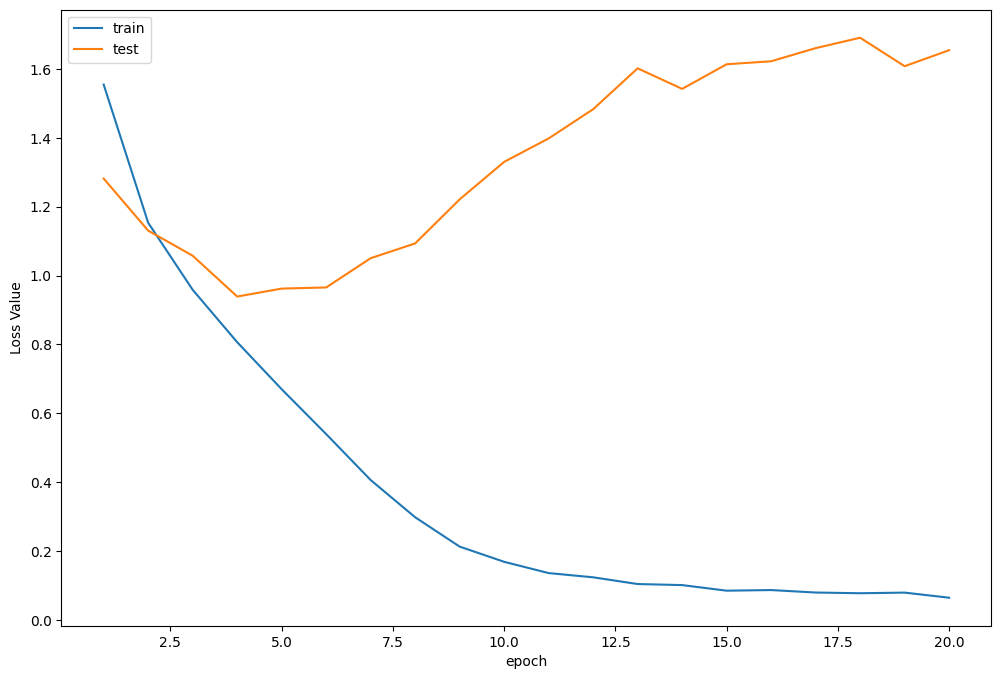

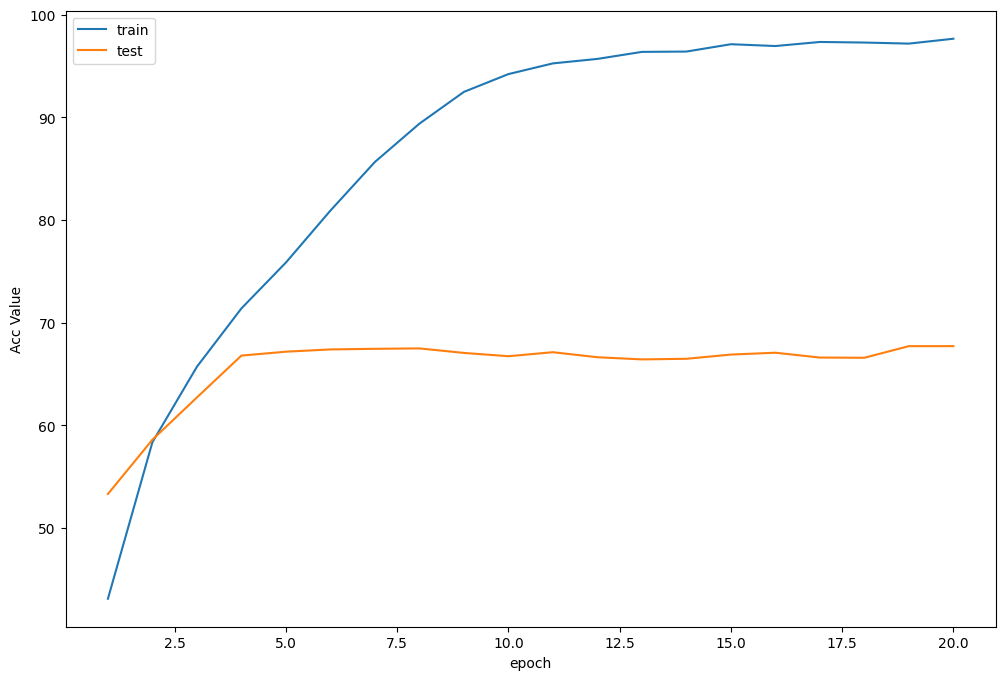

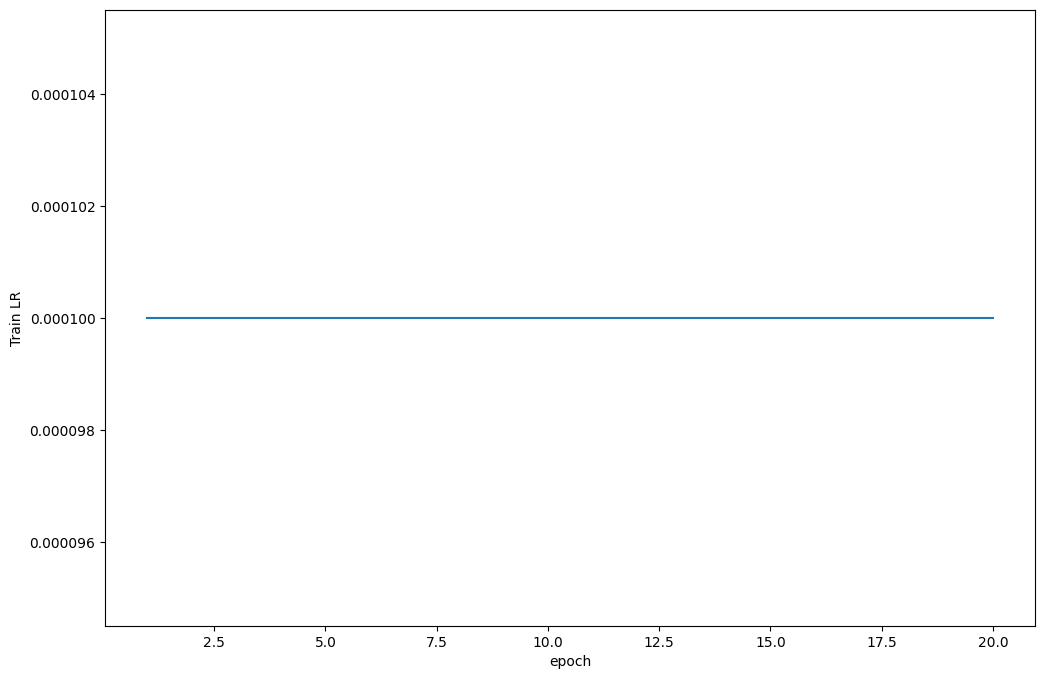

In [34]:
plot_history(epoch ,Acc, Loss, Lr)

In [35]:
# # 查看tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir './log'

## 7. 测试

In [36]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 67.75 %


程序中的 `torch.max(outputs.data, 1)` ，返回一个tuple (元组)

而这里很明显，这个返回的元组的第一个元素是image data，即是最大的 值，第二个元素是label， 即是最大的值 的 索引！我们只需要label（最大值的索引），所以就会有` _ `,predicted这样的赋值语句，表示忽略第一个返回值，把它赋值给` _`， 就是舍弃它的意思；

In [37]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 71.11 %
Accuracy of automobile : 69.37 %
Accuracy of  bird : 56.46 %
Accuracy of   cat : 51.41 %
Accuracy of  deer : 62.76 %
Accuracy of   dog : 60.12 %
Accuracy of  frog : 72.57 %
Accuracy of horse : 73.60 %
Accuracy of  ship : 84.18 %
Accuracy of truck : 75.45 %


Accuracy Rate = 71.875%


<Figure size 2500x400 with 0 Axes>

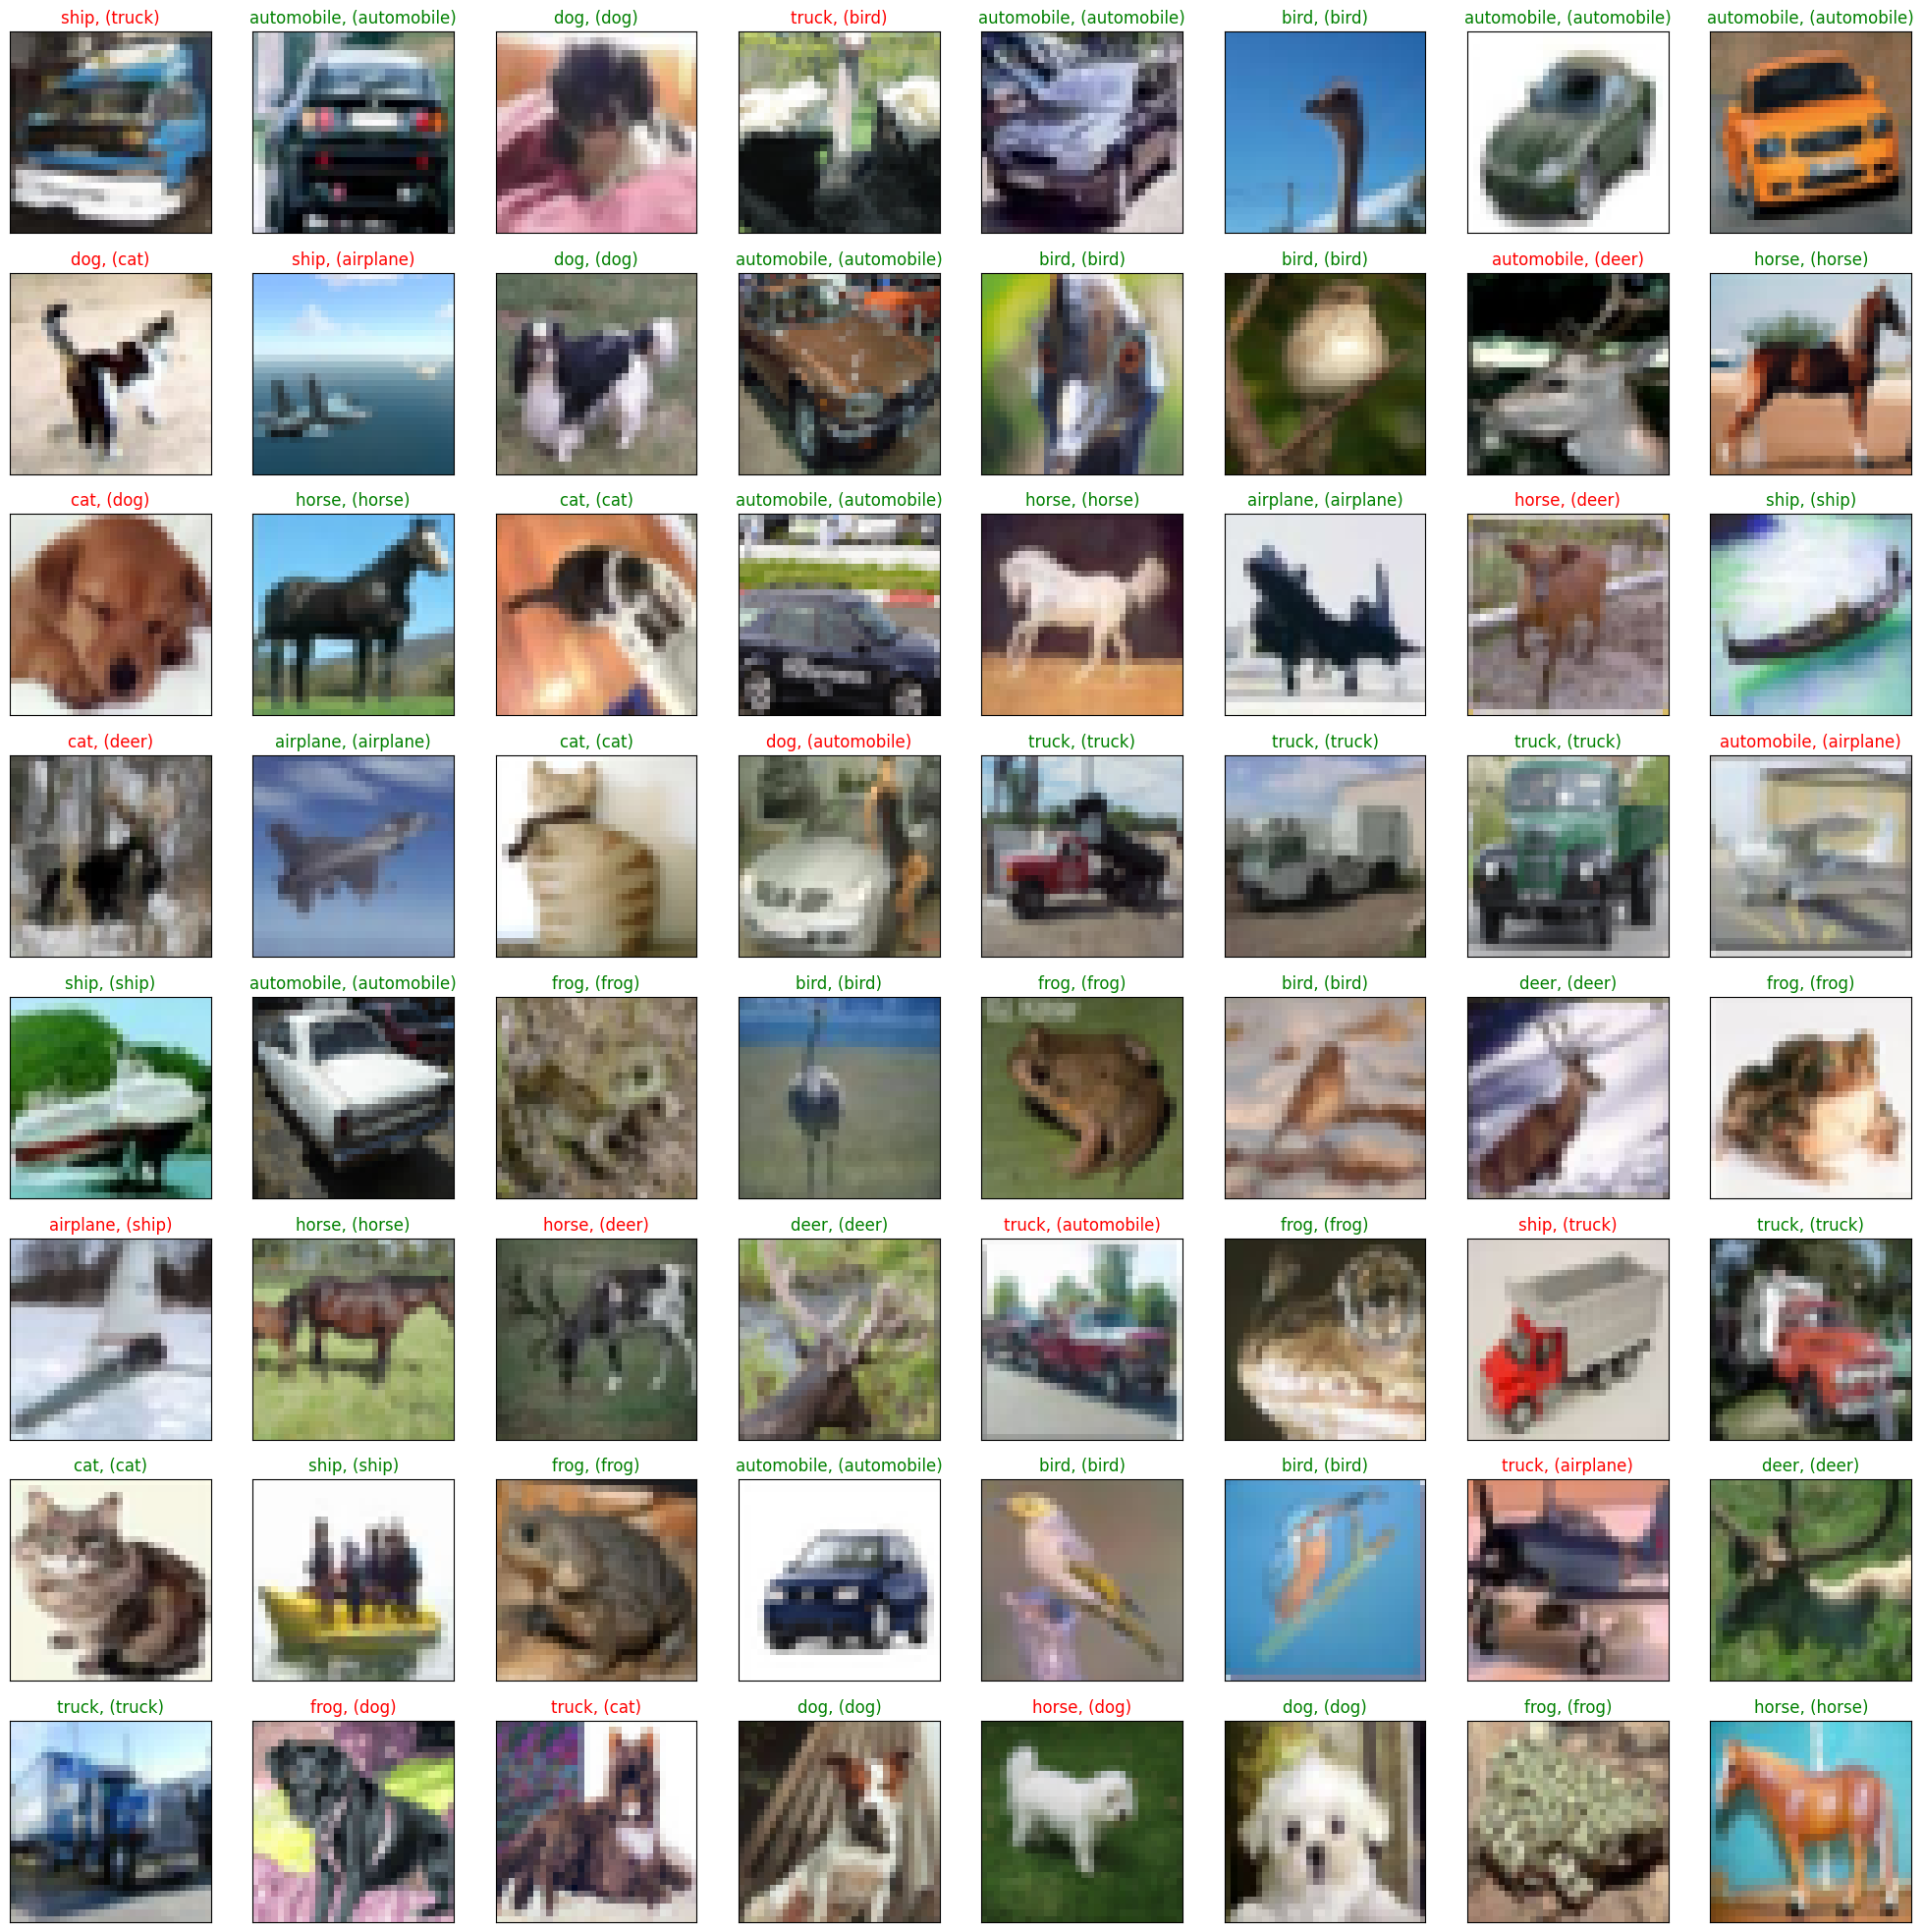

In [38]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

## 8. 保存模型

In [39]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')

## 9. 预测

In [25]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = swin_cifar(patch_size=2, n_classes=10,mlp_ratio=1)

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

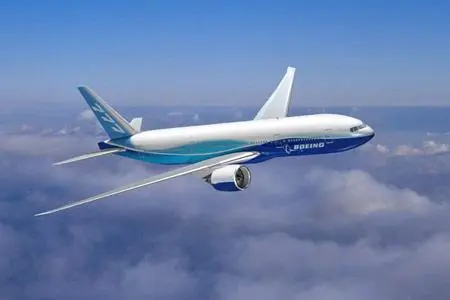

In [26]:
img

In [27]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[1.0000e+00, 2.2268e-09, 2.1475e-06, 1.7415e-11, 2.3119e-08, 3.5245e-10,
         1.2069e-10, 1.3415e-10, 1.8473e-07, 7.2710e-12]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 0
tensor([17.9436], device='cuda:0')
分类 plane


<Response [200]>


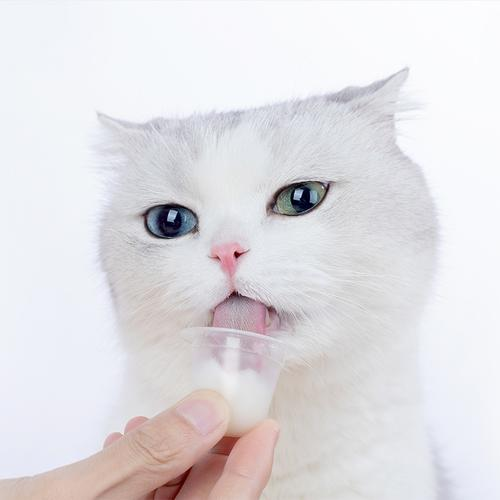

In [28]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

In [29]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[9.8081e-01, 6.6089e-08, 3.0682e-03, 1.3831e-04, 3.3311e-04, 5.0691e-03,
         3.5965e-07, 1.0807e-03, 9.4966e-03, 5.1127e-06]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
类别 0
tensor([7.8766], device='cuda:0')
分类 plane
